*Luis Antonio Ortega Andrés   
Antonio Coín Castro*

# Conjuntos de clasificadores

Este notebook muestra el funcionamiento básico de los conjuntos de clasificadores. Se muestras algunos ejemplos de problemas en 2D para su visualización y con problemas reales para ver sus capacidades y debilidades. Los temas que se tratan son:

* Proceso de combinación de clasificadores base en conjuntos y cómo se modifican las fronteras de decisión 
* Tiempos de entrenamiento y de clasificación en conjuntos de clasificadores y ver cómo varía con respecto a la creación de un único árbol
* Errores de generalización de conjuntos de clasificadores en conjuntos de datos reales
* Importancia de las variables de entrenamiento en el modelo.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt

#### Funciones auxiliares
Se definen conjuntos de datos en 2D para el análisis visual de las fronteras de decisión y cómo cambian con algunos parámetros. Se definin algunas funciones (inspiradas en sklearn) que usaremos a lo largo de la práctica. 

La primera, *createDataSet*, es para crear los problemas, siempre con dos clases y en dos dimensiones. Sus argumentos son:

- *n*, número de patrones en el problema

- *model*, tipo de modelo para la frontera que separa las clases, puede ser 'linear', 'square' o 'sine'

- *ymargin*, margen de separación entre las dos clases, cuanto mayor es *ymargin* más separadas están las clases, valores negativos implican solape entre las clases

- *noise*, introduce un ruido gausiano a la x e y

- *output_boundary*, Si vale True la función devuelve la frontera de decisión

In [2]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()

La función *plotModel* la usaremos para dibujar el resultado de un clasificador sobre el conjunto de datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos, si se pasa None, entonces considera que x e y son la frontera real de decisión y la muestra con plot

- *clf*, el clasificador

- *title*, título para el gráfico

In [3]:
def plotModel(x,y,clase,clf,title=""):
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    elif hasattr(clf, "predict_proba"):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase==0], y[clase==0], c='#FF0000')
        plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

La función, *plotData*, la usaremos para dibujar los datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos

- *style0*, estilo con el que pintamos los puntos de la clase 0

- *style1*, estilo con el que pintamos los puntos de la clase 1

- *title*, título para el gráfico

In [4]:
def plotData(x,y,c,style0,style1,title=''):
    plt.scatter(x[c==0],y[c==0],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

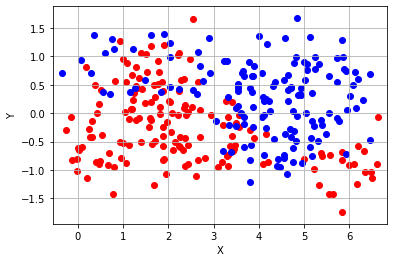

In [5]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.3             # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x1, x2, ytrain, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
x1test, x2test, ytest = createDataSet(n*10, model, ymargin, noise)
plotData(x1,x2,ytrain,{'c':'#FF0000'},{'c':'#0000FF'})
Xtrain = np.concatenate((x1, x2), axis = 1)
Xtest = np.concatenate((x1test, x2test), axis = 1)

## Teorema de Condorcet 

In [6]:
def calcula_p_error_jurado(num_jueces, prob_error):
    p_error_jurado = np.zeros(num_jueces)
    
    # Calculamos la probabilidad de error del jurado desde 1 juez hasta num_jueces,
    # siempre de dos en dos
    for i in range(1, num_jueces + 1, 2):
        # Calculamos a partir de qué valor hay mayoría de errores
        mayoria = 1 + i // 2
        
        # Se modela como una binomial (i, prob_error), y como cada error es independiente, se suman
        p_error_jurado[i - 1] = np.sum(sp.stats.binom.pmf(range(mayoria, i + 1), i, prob_error))
    
    return p_error_jurado

def plot_prob_error(p_error_jurado, semilogy = False):
    if semilogy:
        plt.semilogy(range(1, len(p_error_jurado) + 1, 2), p_error_jurado[::2])
    else:
        plt.plot(range(1, len(p_error_jurado) + 1, 2), p_error_jurado[::2])
    
    plt.ylabel('Prob. de error del jurado')
    plt.xlabel('Número de jueces')
    plt.show()

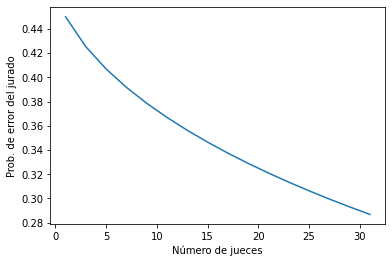

In [7]:
prob_error = 0.45  # Probabilidad de error de cada juez
num_jueces = 31  # Número de jueces (impar para evitar empates)

plot_prob_error(calcula_p_error_jurado(num_jueces, prob_error))

¿Qué sucede si la probabilidad de equivocarse de cada juez es mayor que 0.5?

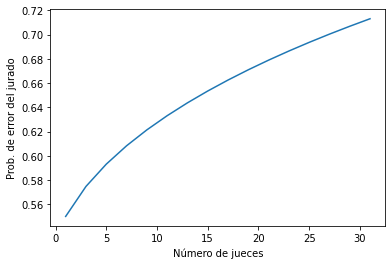

In [8]:
prob_error = 0.55  # Probabilidad de error de cada juez
plot_prob_error(calcula_p_error_jurado(num_jueces, prob_error))

Vemos que aumenta la probabilidad de error del jurado conforme aumentamos el número de jueces.

----

¿Cuántos jueces necesitas para estar tener una prob del 99% de que el jurado acierte con prob_error = 0.3? ¿y con prob_error=0.1? ¿y con 0.45?

In [9]:
prob_error = [0.3, 0.1, 0.45]
num_jueces = [1, 1, 1]
threshold = 0.01

for i, p in enumerate(prob_error):
    p_error_jurado = calcula_p_error_jurado(num_jueces[i], p)
    idx = np.where(p_error_jurado[::2] <= threshold)[0]
    
    while len(idx) == 0:
        num_jueces[i] += 2
        p_error_jurado = calcula_p_error_jurado(num_jueces[i], p)
        idx = np.where(p_error_jurado[::2] <= threshold)[0]
    
    print(f"Número de jueces para tener 99% de acierto con p_error = {p} es: {num_jueces[i]}.")

Número de jueces para tener 99% de acierto con p_error = 0.3 es: 31.
Número de jueces para tener 99% de acierto con p_error = 0.1 es: 5.
Número de jueces para tener 99% de acierto con p_error = 0.45 es: 539.


## Muestras bootstrap y bagging
Una muestra bootstrap estándar consiste realizar N extracciones aleatorias con reemplazamiento de una urna con N elementos. Algunas variaciones incluyen:

* Realizar M extracciones con $M\neq N$
* Realizar las extracciones sin reemplazamiento

Observamos el efecto que tienen estas variaciones sobre la fracción de instancias originales que se seleccionan.

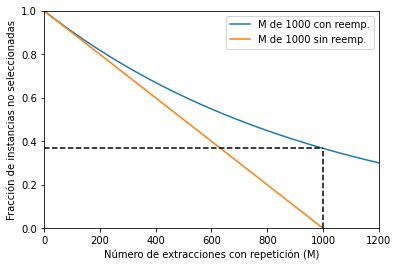

In [10]:
M = np.array(range(1,1201,1))
M2 = np.array(range(1,1001,1))
N = 1000

plt.plot(M, ((N-1)/N)**M, label='M de {} con reemp.'.format(N))
plt.plot(M2, (N-M2)/N, label='M de {} sin reemp.'.format(N))
plt.plot([0,N],[((N-1)/N)**N,((N-1)/N)**N],'k--')
plt.plot([N,N],[0,((N-1)/N)**N],'k--')
plt.xlim([0,M[-1]])
plt.ylim([0,1])
plt.ylabel('Fracción de instancias no seleccionadas')
plt.xlabel('Número de extracciones con repetición (M)')
_=plt.legend()

Implementamos un Bagging sencillo.

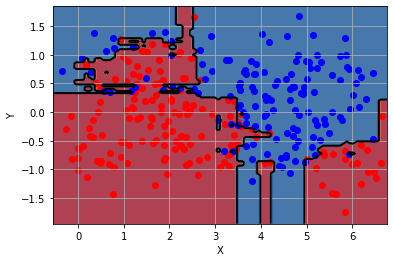

In [11]:
from sklearn.tree import DecisionTreeClassifier

class BaggingCasero:
    def __init__(self, n_estimators = 101):
        self.n_estimators = n_estimators
        self._estimators = []
    
    def fit(self, X, y):
        N = X.shape[0]
        for i in range(self.n_estimators):
            # Muestra bootstrap de tamaño N
            b = np.random.choice(np.arange(0, N), size = N, replace = True)
            X_b, y_b = X[b], y[b]
            
            # Entrenamos un clasificador con la muestra bootstrap
            tree = DecisionTreeClassifier().fit(X_b, y_b)
            self._estimators.append(tree)
            
        return self
            
    def predict(self, X):
        votes = np.zeros((X.shape[0], len(self._estimators)))
        
        # Calcula la salida de cada árbol para cada dato
        for j, estimator in enumerate(self._estimators):
            votes[:, j] = estimator.predict(X)
        
        mode = sp.stats.mode(votes, axis = 1)[0]
        return mode
            
bagging = BaggingCasero()
bagging.fit(Xtrain, ytrain)
plotModel(x1,x2,ytrain,bagging)

## Visualizar el conjunto
Se entrena un random forest con 3 árboles para visualizar la frontera de decisión cuándo se combinan en el conjunto de clasificadores y cada árbol por separado.

Score train = 1.000000
Score test = 0.851000
Score test tres primeros árboles = 0.821000,0.767000,0.795667


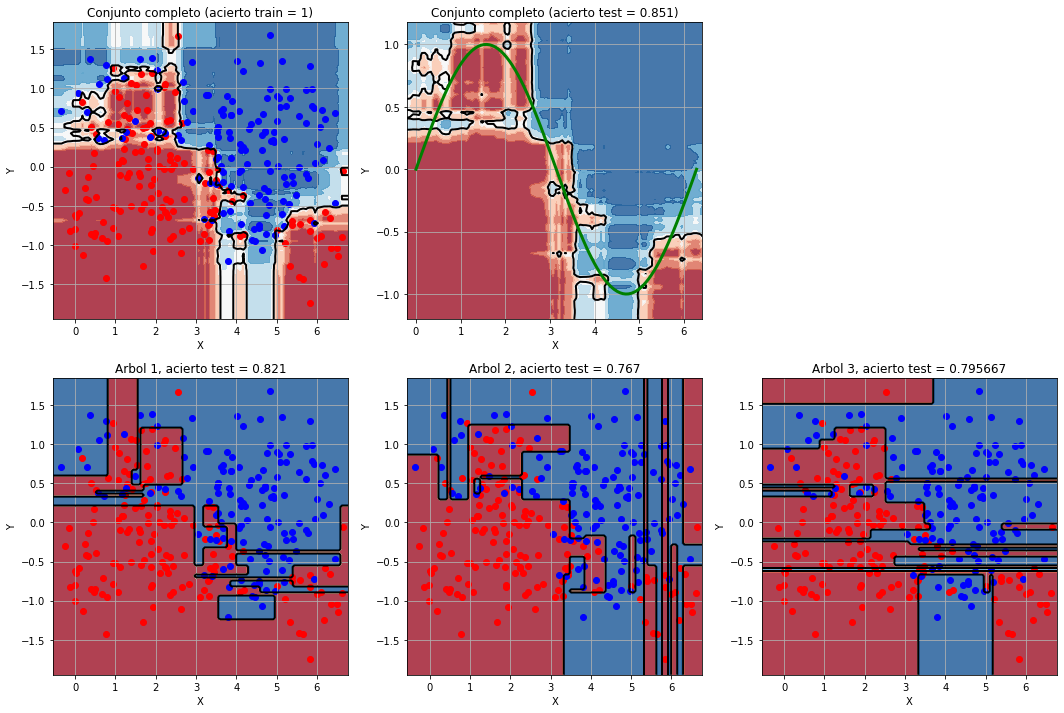

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Construcción del clasificador:
np.random.seed(11)
clf = RandomForestClassifier(n_estimators=301) # <= Modif este valor 3, 31 y 301(antes responde a las cuestiones de arriba)
clf.fit(Xtrain, ytrain)

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(Xtrain, ytrain)
print("Score train = %f" % (score_train))
score_test = clf.score(Xtest, ytest)
print("Score test = %f" % (score_test))

scores_single_trees_test = [dt.score(Xtest, ytest) for dt in clf.estimators_[0:3]]

print("Score test tres primeros árboles = %f,%f,%f" % tuple(scores_single_trees_test))

# Gráficas:
plt.figure(figsize=(18,12))

plt.subplot(231)
t = "Conjunto completo (acierto train = {:g})".format(score_train)
plotModel(x1,x2,ytrain,clf,t)

plt.subplot(232)
t = "Conjunto completo (acierto test = {:g})".format(score_test)
plotModel(xbnd,ybnd,None,clf,t)

# Se muestra el acierto y frontera de los 3 primeros árboles
# del conjunto
for i in [1,2,3]:
    plt.subplot(2,3,3+i)
    t = "Arbol {}, acierto test = {:g}".format(i,scores_single_trees_test[i-1])
    plotModel(x1,x2,ytrain,clf.estimators_[i-1],t)

